In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import os
os.environ['TRANSFORMERS_CACHE'] = "../workspace"

In [3]:
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig

/tmp/ipykernel_9693/1250825710.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/root/.local/share/virtualenvs/task_vector_experiment-wEAZHMtr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/.local/share/virtualenvs/task_vector_experiment-wEAZHMtr/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use

In [4]:
np.random.seed(42)

# Helper Functions

In [5]:
def get_completion(
        model,
        tokenizer,
        text,
        max_new_tokens=30,
        **kwargs
    ):
    eos_token_ids_custom = [tokenizer.eos_token_id] + [29889]
    with torch.no_grad():
        output = model.generate(
            **tokenizer(text, return_tensors='pt').to(model.device),
            max_new_tokens=max_new_tokens,
            eos_token_id=eos_token_ids_custom,
            **kwargs
        )
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    return completion, output[0]

# Explore Models

### GPT2-XL

In [5]:
model_name_or_path = "openai-community/gpt2-xl"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="right", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

model.safetensors: 100%|██████████| 6.43G/6.43G [00:26<00:00, 242MB/s] 
generation_config.json: 100%|██████████| 124/124 [00:00<00:00, 780kB/s]
vocab.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.53MB/s]
merges.txt: 100%|██████████| 456k/456k [00:00<00:00, 2.21MB/s]
tokenizer.json: 100%|██████████| 1.36M/1.36M [00:00<00:00, 2.62MB/s]


In [9]:
text = """Answer only A, B, C, or D. Choose the CORRECT option.
Option A: 1 + 2 = 7
Option B: 5 + 4 = 9
Option C: 6 + 6 = 11
Option D: 3 + 5 = 2
The correct option is Option B

Option A: 2 + 2 = 4
Option B: 0 + 9 = 8
Option C: 4 + 7 = 10
Option D: 4 + 3 = 1
The correct option is Option A

Option A: 9 + 1 = 11
Option B: 5 + 2 = 4
Option C: 7 + 8 = 16
Option D: 6 + 6 = 12
The correct option is Option"""

In [10]:
get_completion(
    model,
    tokenizer,
    text,
    max_new_tokens=1
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


('Answer only A, B, C, or D. Choose the CORRECT option.\nOption A: 1 + 2 = 7\nOption B: 5 + 4 = 9\nOption C: 6 + 6 = 11\nOption D: 3 + 5 = 2\nThe correct option is Option B\n\nOption A: 2 + 2 = 4\nOption B: 0 + 9 = 8\nOption C: 4 + 7 = 10\nOption D: 4 + 3 = 1\nThe correct option is Option A\n\nOption A: 9 + 1 = 11\nOption B: 5 + 2 = 4\nOption C: 7 + 8 = 16\nOption D: 6 + 6 = 12\nThe correct option is Option A',
 tensor([33706,   691,   317,    11,   347,    11,   327,    11,   393,   360,
            13, 17489,   262, 23929, 23988,  3038,    13,   198, 19722,   317,
            25,   352,  1343,   362,   796,   767,   198, 19722,   347,    25,
           642,  1343,   604,   796,   860,   198, 19722,   327,    25,   718,
          1343,   718,   796,  1367,   198, 19722,   360,    25,   513,  1343,
           642,   796,   362,   198,   464,  3376,  3038,   318, 16018,   347,
           198,   198, 19722,   317,    25,   362,  1343,   362,   796,   604,
           198, 19722,   347,   

### Llama2-7B-Chat

In [6]:
model_name_or_path = "meta-llama/Llama-2-7b-chat-hf"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

Loading checkpoint shards: 100%|██████████| 2/2 [00:13<00:00,  6.51s/it]


### Mistral

In [218]:
model_name_or_path = "mistralai/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.bfloat16, device_map="auto")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

model.safetensors.index.json: 100%|██████████| 25.1k/25.1k [00:00<00:00, 28.3MB/s]
model-00001-of-00002.safetensors:   0%|          | 31.5M/9.94G [00:00<01:33, 106MB/s]


KeyboardInterrupt: 

### Test

In [9]:
system_prompt = "Pick exactly one of the options A, B, C, or D."
query = """Which of the following statements is true?
A: 8 + 11 = 20
B: 19 + 0 = 9
C: 16 + 6 = 22
D: 3 + 5 = 2"""
response = "The true statement is:"
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": query},
    {"role": "assistant", "content": response},
]
prompt = tokenizer.apply_chat_template(messages, return_tensors="pt", tokenize=False)[:-5] + "\n\n"

In [13]:
completion, tokens = get_completion(
    model,
    tokenizer,
    prompt,
    max_new_tokens=20,
    do_sample=False,
)
print(completion)

[INST] <<SYS>>
Pick exactly one of the options A, B, C, or D.
<</SYS>>

Which of the following statements is true?
A: 8 + 11 = 20
B: 19 + 0 = 9
C: 16 + 6 = 22
D: 3 + 5 = 2 [/INST] The true statement is:

A: 8 + 11 = 20


In [14]:
system_prompt = "Pick exactly one of the options A, B, C, or D."
query = """Which of the following statements is true?
A: Rio de Janeiro is a city in Japan.
B: Bangkok is a city in Thailand.
C: Beijing is a city in United Kingdom.
D: Qujing is a city in Brazil."""
response = "The true statement is:"
messages = [
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": query},
    {"role": "assistant", "content": response},
]
prompt = tokenizer.apply_chat_template(messages, return_tensors="pt", tokenize=False)[:-5] + "\n\n"

In [203]:
print(labeled_prompts[100][0])

<s>[INST] <<SYS>>
Answer only A, B, C, or D. Which of the following statements is true?
<</SYS>>

A: 13 + 17 = 26
B: 2 + 10 = 28
C: 5 + 10 = 15
D: 16 + 18 = 20 [/INST] The answer is


In [136]:
print(labeled_prompts[33][1])

A


In [14]:
prompt = """"Pick exactly one of the options A, B, C, or D.
Pick the True statement.
A: Rio de Janeiro is a city in Japan.
B: Bangkok is a city in Thailand.
C: Beijing is a city in United Kingdom.
D: Qujing is a city in Brazil.

The answer is
"""

In [10]:
prompt = "Is it true that Rio de Janeiro is a city in Japan? Answer:"

In [15]:
completion, tokens = get_completion(
    model,
    tokenizer,
    prompt,
    max_new_tokens=20,
    do_sample=False,
)
print(completion)

[INST] <<SYS>>
Pick exactly one of the options A, B, C, or D.
<</SYS>>

Which of the following statements is true?
A: Rio de Janeiro is a city in Japan.
B: Bangkok is a city in Thailand.
C: Beijing is a city in United Kingdom.
D: Qujing is a city in Brazil. [/INST] The true statement is:

B: Bangkok is a city in Thailand.


# Generate Simple Test Data

### City Data

In [7]:
city_data = pd.read_csv("worldcities.csv")

In [8]:
true_statements = []
for idx, row in city_data.iterrows():
    city = row["city"]
    country = row["country"]
    true_statements.append(
        f"{city} is in {country}."
    )

In [9]:
countries = city_data["country"].unique()

In [10]:
n = len(city_data)
false_statements = []
for idx, row in city_data.iterrows():
    city = row["city"]
    possible_false_countries = np.delete(countries, np.where(countries == row["country"]))
    false_country_indices = list(
        np.random.choice(range(len(possible_false_countries)), size=4, replace=False)
    )
    for false_country in possible_false_countries[false_country_indices]:
        false_statements.append(
            f"{city} is in {false_country}."
        )

In [11]:
n_group = 125

answer_choices = ["A", "B", "C", "D"]
city_query_data = []

for correct_choice in answer_choices:
    true_statement_idxs = np.random.choice(np.arange(len(true_statements)), size=n_group, replace=False)
    for true_statement in np.array(true_statements)[true_statement_idxs]:
        false_statement_idxs = list(
            np.random.choice(np.arange(len(false_statements)), size=3, replace=False)
        )

        statements = []
        for choice in answer_choices:
            if choice == correct_choice:
                statement = f"{choice}: {true_statement}"
            else:
                false_statement = false_statements[false_statement_idxs.pop()]
                statement = f"{choice}: {false_statement}"
            statements.append(statement)

        city_query_data.append(
            ("\n".join(statements), correct_choice)
        )

### Addition Data

In [227]:
from itertools import product

def generate_addition_data(n=21):
    all_combinations = list(product(range(n), repeat=2))
    unique_combinations = [(x, y) for x, y in all_combinations if x <= y]
    xs = [x for x, y in unique_combinations]
    ys = [y for x, y in unique_combinations]
    results = [x + y for x, y in unique_combinations]
    return xs, ys, results

In [232]:
max_n = 10
addition_data = generate_addition_data(n=max_n + 1)
n_group = len(addition_data[0]) // 4

In [233]:
false_statements = []
for x, y, result in zip(addition_data[0], addition_data[1], addition_data[2]):
    values = np.delete(np.arange(2*max_n), np.where(np.arange(2*max_n) == result))
    false_results = list(
        np.random.choice(values, size=4, replace=False)
    )
    for false_result in false_results:
        false_statements.append(
            f"{x} + {y} = {false_result}"
        )

In [234]:
true_statements = []
for x, y, result in zip(addition_data[0], addition_data[1], addition_data[2]):
    true_statements.append(
        f"{x} + {y} = {result}"
    )

In [235]:
answer_choices = ["A", "B", "C", "D"]
addition_query_data = []
i = 0
for correct_choice in answer_choices:
    for _ in range(n_group):
        true_statement = true_statements[i]

        false_statement_indices = list(
            np.random.choice(np.arange(len(false_statements)), size=3, replace=False)
        )

        statements = []
        for choice in answer_choices:
            if choice == correct_choice:
                statement = f"{choice}: {true_statement}"
            else:
                false_statement = false_statements[false_statement_indices.pop()]
                statement = f"{choice}: {false_statement}"
            statements.append(statement)

        addition_query_data.append(
            ("\n".join(statements), correct_choice)
        )
        i += 1

# Get LLama2 accuracy on city data

In [12]:
system_prompt = "Pick exactly one of the options A, B, C, or D."
query_prefix = "Which of the following statements is true?\n"
response = "The true statement is:"
labeled_prompts = []
for query, label in city_query_data:
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": query_prefix + query},
        {"role": "assistant", "content": response},
    ]
    prompt = tokenizer.apply_chat_template(
        messages, return_tensors="pt", tokenize=False
    )[:-5] + "\n\n"
    labeled_prompts.append(
        (prompt, label)
    )

In [13]:
score = 0
completions = []
answers = []
for prompt, label in labeled_prompts:
    completion, tokens = get_completion(
        model,
        tokenizer,
        prompt,
        max_new_tokens=2,
        do_sample=False,
    )
    completions.append(completion)
    choice = completion[-2:]
    answers.append(choice)
    if label in choice:
        score += 1

/root/.local/share/virtualenvs/task_vector_experiment-wEAZHMtr/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/.local/share/virtualenvs/task_vector_experiment-wEAZHMtr/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [14]:
acc = score / len(labeled_prompts)
print(f"Accuracy: {acc}")

Accuracy: 0.69


# Linear probe for ground truth

In [15]:
def get_hiddens_states_from_forward_passes(
    model,
    tokenizer,
    input,
    layers=None,
    model_name = "meta-llama/Llama-2-7b-chat-hf",
    **generation_kwargs 
):
    layers = layers or [15]

    generation_config = GenerationConfig.from_pretrained(
        model_name, **generation_kwargs 
    )
    model.generation_config = generation_config
    with torch.no_grad():
        output = model(
            **tokenizer(input, return_tensors='pt', padding=True).to(model.device),
            output_hidden_states=True,
        )
    output_cpu = torch.stack(
        [output["hidden_states"][layer].to("cpu") for layer in layers], dim=0
    )
    return output_cpu

In [16]:
def get_string_tokens_from_text(text, tokenizer):
    inpt = tokenizer(text, return_tensors='pt')
    return tokenizer.convert_ids_to_tokens(inpt["input_ids"][0])

In [18]:
def get_statement_token_indices_for_queries(queries, tokenizer, offset=1):
    a_indices = []
    b_indices = []
    c_indices = []
    d_indices = []
    for query in queries:
        query_tokens = get_string_tokens_from_text(query, tokenizer)
        newline_indices = [index for index, value in enumerate(query_tokens) if value == '<0x0A>']
        a_newline_idx = newline_indices[5]
        a_indices.append(
            a_newline_idx - offset
        )
        b_newline_idx = newline_indices[6]
        b_indices.append(
            b_newline_idx - offset
        )
        c_newline_idx = newline_indices[7]
        c_indices.append(
            c_newline_idx - offset
        )
        last_open_bracket_idx = [index for index, value in enumerate(query_tokens) if value == '▁['][-1]
        d_indices.append(
            last_open_bracket_idx - offset
        )
    return a_indices, b_indices, c_indices, d_indices

In [19]:
def adjust_indices_for_padding(prompts, indices, tokenizer):
    individual_prompt_lengths = []
    for prompt in prompts:
        prompt_tokens = tokenizer(prompt, return_tensors='pt', padding=True)
        individual_prompt_lengths.append(
            prompt_tokens["input_ids"].shape[1]
        )
    max_prompt_length = max(individual_prompt_lengths)
    for i in range(len(prompts)):
        indices[i] += max_prompt_length - individual_prompt_lengths[i]
    return indices

In [20]:
def get_labeled_hidden_states(
    labeled_prompts,
    correct_indices,
    incorrect_indices,
    layers=None,
    chunk_size=5,
):
    layers = layers or [15] 
    hs = []
    labels = []

    for i in range(0, len(labeled_prompts), chunk_size):
        chunk = labeled_prompts[i:i+chunk_size]
        correct_idx_chunk = correct_indices[i:i+chunk_size]
        incorrect_idx_chunk = incorrect_indices[i:i+chunk_size]
        queries = [query for query, _ in chunk]
        correct_idx_chunk = adjust_indices_for_padding(queries, correct_idx_chunk, tokenizer)
        incorrect_idx_chunk = adjust_indices_for_padding(queries, incorrect_idx_chunk, tokenizer)
        h = get_hiddens_states_from_forward_passes(
            model,
            tokenizer,
            queries,
            layers=layers,
            model_name = "meta-llama/Llama-2-7b-chat-hf",
            max_new_tokens=1 
        ).to("cpu")
        h = einops.rearrange(h, 'layer prompt token hidden -> prompt layer token hidden')
        
        hs.extend(
            list(h[range(len(queries)), :, correct_idx_chunk])
        )
        labels.extend(
            [1] * chunk_size
        )
        hs.extend(
            list(h[range(len(queries)), :, incorrect_idx_chunk])
        )
        labels.extend(
            [-1] * chunk_size
        )
    
    return hs, labels

### Train Linear Probe 

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

In [22]:
def shuffle_data(data, shuffle_indices=None):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    shuffle_indices = shuffle_indices or np.random.shuffle(np.arange(len(data)))
    data = data[shuffle_indices][0]
    return data

In [23]:
a_indices, b_indices, c_indices, d_indices = get_statement_token_indices_for_queries(
    [query for query, _ in labeled_prompts], tokenizer, offset=2
)

In [24]:
correct_indices = a_indices[:125] + b_indices[125:250] + c_indices[250:375] + d_indices[375:]
incorrect_indices = []
for i in range(125):
    incorrect_indices.append(
        np.random.choice([b_indices[i], c_indices[i], d_indices[i]])
    )
for i in range(125, 250):
    incorrect_indices.append(
        np.random.choice([a_indices[i], c_indices[i], d_indices[i]])
    )
for i in range(250, 375):
    incorrect_indices.append(
        np.random.choice([a_indices[i], b_indices[i], d_indices[i]])
    )
for i in range(375, 500):
    incorrect_indices.append(
        np.random.choice([a_indices[i], b_indices[i], c_indices[i]])
    )

In [25]:
def get_balanced_train_test_split(data, labels, unique_labels=None, test_size=0.5, random_state=42):
    X_train, X_test, Y_train, Y_test = [], [], [], []
    unique_labels = unique_labels or [1, -1]
    for label in unique_labels:
        data_with_label = [d for d, l in zip(data, labels) if l == label]
        prompts_train, prompts_test, labels_train, labels_test = train_test_split(
            data_with_label, [label] * len(data_with_label), test_size=test_size, random_state=random_state
        )
        X_train.extend(prompts_train)
        X_test.extend(prompts_test)
        Y_train.extend(labels_train)
        Y_test.extend(labels_test)
    return X_train, X_test, Y_train, Y_test

In [26]:
chunk_size = 5
layers = list(range(33))

hs, labels = get_labeled_hidden_states(
    labeled_prompts,
    correct_indices,
    incorrect_indices,
    layers=layers,
    chunk_size=chunk_size
)
hs = [h.to(torch.float32) for h in hs]
shuffle_indices = np.random.shuffle(np.arange(len(hs)))
hs = shuffle_data(hs, shuffle_indices=shuffle_indices)
labels = shuffle_data(labels, shuffle_indices=shuffle_indices)
shuffled_labeled_prompts = shuffle_data(labeled_prompts, shuffle_indices=shuffle_indices)

In [27]:
data = [(h, prompt) for h, prompt in zip(hs, shuffled_labeled_prompts)]
X_train, X_test, Y_train, Y_test = get_balanced_train_test_split(data, labels)
X_hs_train = np.array([x[0] for x in X_train])
X_prompt_train = np.array([x[1] for x in X_train])
X_hs_test = np.array([x[0] for x in X_test])
X_prompt_test = np.array([x[1] for x in X_test])

In [28]:
import numpy as np
show = False

probes = []
train_accs = []
train_rocs = []
test_accs = []
test_rocs = []

for idx, layer in enumerate(layers):
    x_train = np.array([x[idx] for x in X_hs_train])
    x_test = np.array([x[idx] for x in X_hs_test])

    probe = LinearRegression(fit_intercept=False)
    probe.fit(x_train, Y_train)

    train_predictions = probe.predict(x_train)
    train_accuracy = accuracy_score(Y_train, np.where(train_predictions > 0, 1, -1))
    fpr, tpr, thresholds = roc_curve(Y_train, train_predictions)
    train_roc_auc = auc(fpr, tpr)

    test_predictions = probe.predict(x_test)
    test_accuracy = accuracy_score(Y_test, np.where(test_predictions > 0, 1, -1))
    fpr, tpr, thresholds = roc_curve(Y_test, test_predictions)
    test_roc_auc = auc(fpr, tpr)

    probes.append(probe)
    train_accs.append(train_accuracy)
    train_rocs.append(train_roc_auc)
    test_accs.append(test_accuracy)
    test_rocs.append(test_roc_auc)

    if show:
        print()
        print(f"Layer {layer} Results")
        print(f"Train Acc: {train_accuracy}")
        print(f"Train ROC: {train_roc_auc}")
        print(f"Test Acc: {test_accuracy}")
        print(f"Test ROC: {test_roc_auc}")
        print()


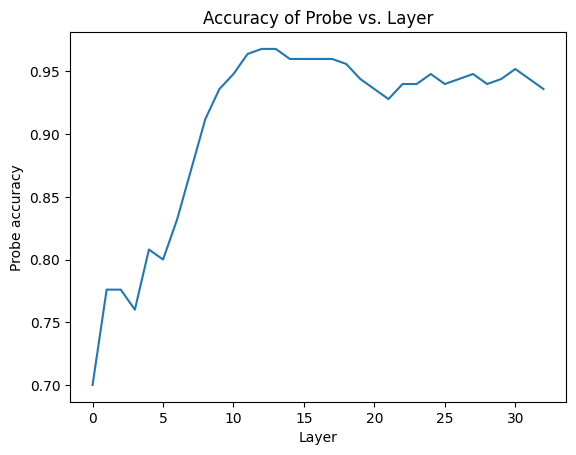

In [29]:
import matplotlib.pyplot as plt

plt.plot(layers, test_accs)
plt.xlabel('Layer')
plt.ylabel('Probe accuracy')
plt.title('Accuracy of Probe vs. Layer')
plt.show()

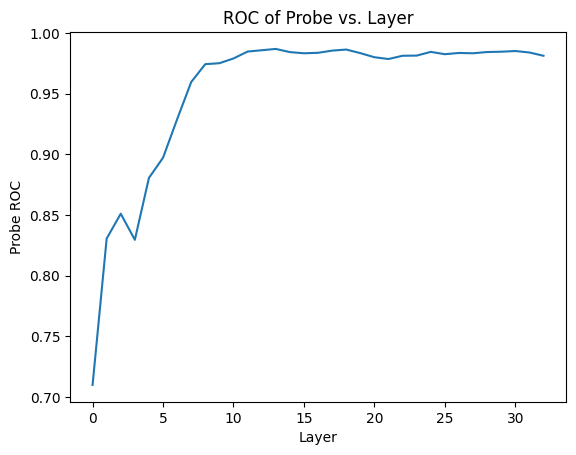

In [30]:
import matplotlib.pyplot as plt

plt.plot(layers, test_rocs)
plt.xlabel('Layer')
plt.ylabel('Probe ROC')
plt.title('ROC of Probe vs. Layer')
plt.show()

### Test causal influence of probe direction

In [32]:
highest_test_accuracy_index = np.argmax(test_accs)

In [33]:
def get_probe_truth_scores_for_options(
    h, probe, a_idx, b_idx, c_idx, d_idx, layer_idx=highest_test_accuracy_index, pos_offset=0
):
    h_numpy = h.to(torch.float32).squeeze(1).numpy()
    truth_scores = probe.predict(
        h_numpy[
            layer_idx,
            [a_idx + pos_offset, b_idx + pos_offset, c_idx + pos_offset, d_idx + pos_offset]
        ]
    )
    return truth_scores

In [34]:
from model import Llama2Helper

wrapped_model = Llama2Helper(model, tokenizer)
generation_config = GenerationConfig.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf", max_new_tokens=1, eos_token_id=[tokenizer.eos_token_id]
)
wrapped_model.model.generation_config = generation_config

In [35]:
test_prompts_a = [p[0] for p in X_prompt_test if p[1] == "A"]
test_prompts_b = [p[0] for p in X_prompt_test if p[1] == "B"]
test_prompts_c = [p[0] for p in X_prompt_test if p[1] == "C"]  
test_prompts_d = [p[0] for p in X_prompt_test if p[1] == "D"]

In [36]:
a_ids_test, b_ids_test, c_ids_test, d_ids_test = get_statement_token_indices_for_queries(
    [p[0] for p in X_prompt_test], tokenizer, offset=2
)

In [37]:
wrapped_model.reset_all()

In [43]:
def steer_towards_choice(wrapped_model, prompts, ids, target, strength=3., get_control_results=False):
    control = 0
    intervention = 0

    for (prompt, label), a_idx in zip(prompts, ids):
        if get_control_results:
            answer_control, _ = get_completion(
                wrapped_model.model,
                tokenizer,
                prompt,
                max_new_tokens=1,
                do_sample=False,
            )
            choice = answer_control[-2:]
            if target in choice:
                control += 1

        for layer in range(len(layers) - 1):
            layer_probe = probes[layer]
            truth_vector = layer_probe.coef_
            truth_tensor = torch.tensor(truth_vector).to(torch.float32).to("cuda")
            truth_tensor /= torch.linalg.norm(truth_tensor)
            # for pos in range(b_index - 5, b_index + 2):
            #     wrapped_model.set_add_activations(layer, -20.*truth_tensor, pos)
            for pos in range(a_idx - 5, a_idx + 2):
                wrapped_model.set_add_activations(layer, strength*truth_tensor, pos)

        answer_intervention = wrapped_model.generate_text(
            prompt,
            # max_length=1,
            do_sample=False,
        )
        choice = answer_intervention[-2:]
        if target in choice:
            intervention += 1

        wrapped_model.reset_all()

    return intervention, control

In [56]:
wrapped_model.reset_all()

In [64]:
strengths = [-1.5, -1., -0.5, 0., 0.5, 1., 1.5]
intervention_results = {
    "A": [],
    "B": [],
    "C": [],
    "D": [],
}

for ids_test, target in zip([a_ids_test, b_ids_test, c_ids_test, d_ids_test], ["A", "B", "C", "D"]):
    for strength in strengths:
        intervention_result, _ = steer_towards_choice(
            wrapped_model, X_prompt_test, ids_test, target, strength=strength
        )
        intervention_results[target].append(intervention_result)
        wrapped_model.reset_all()

In [63]:
wrapped_model.reset_all()

In [61]:
intervention_result, _ = steer_towards_choice(
    wrapped_model, X_prompt_test, a_ids_test, "A", strength=0.5
)

/root/.local/share/virtualenvs/task_vector_experiment-wEAZHMtr/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/.local/share/virtualenvs/task_vector_experiment-wEAZHMtr/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [67]:
len([p for p in X_prompt_test if p[1] == "B"])

71

In [68]:
len([p for p in X_prompt_test if p[1] == "C"])

62

In [69]:
intervention_results["B"]

[41, 81, 112, 115, 122, 141, 167]

In [71]:
intervention_results["C"]

[0, 2, 16, 27, 40, 31, 64]

In [55]:
strengths

[-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5]

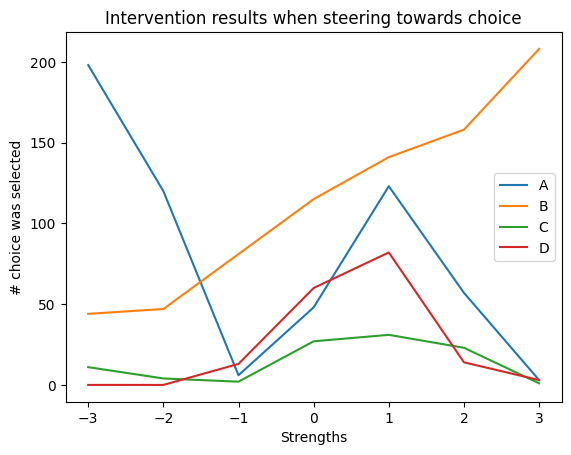

In [59]:
plt.plot(range(-3, 4), intervention_results["A"], label="A")
plt.plot(range(-3, 4), intervention_results["B"], label="B")
plt.plot(range(-3, 4), intervention_results["C"], label="C")
plt.plot(range(-3, 4), intervention_results["D"], label="D")

plt.xlabel('Strengths')
plt.ylabel('# choice was selected')
plt.title('Intervention results when steering towards choice')
plt.legend()
plt.show()

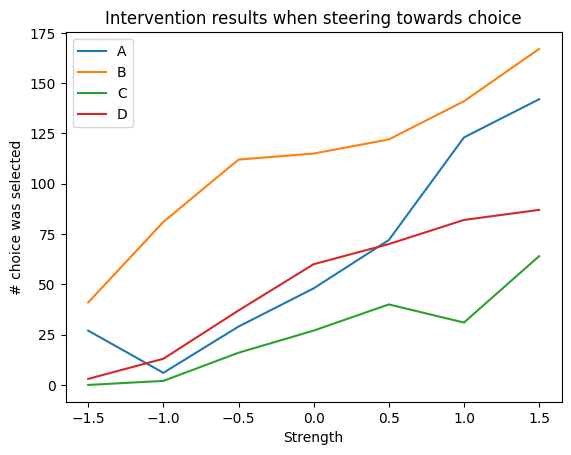

In [66]:
plt.plot(strengths, intervention_results["A"], label="A")
plt.plot(strengths, intervention_results["B"], label="B")
plt.plot(strengths, intervention_results["C"], label="C")
plt.plot(strengths, intervention_results["D"], label="D")

plt.xlabel('Strength')
plt.ylabel('# choice was selected')
plt.title('Intervention results when steering towards choice')
plt.legend()
plt.show()

In [ ]:
a_control, a_intervention = steer_towards_choice(X_prompt_test, a_ids_test, "A", strength=1.)

In [148]:
print(a_control, a_intervention)

48 86


In [ ]:
a_control, a_intervention = steer_towards_choice(X_prompt_test, a_ids_test, "A")

In [134]:
print(a_control, a_intervention)

48 195


In [ ]:
b_control, b_intervention = steer_towards_choice(X_prompt_test, b_ids_test, "B")

In [136]:
print(b_control, b_intervention)

120 147


In [ ]:
c_control, c_intervention = steer_towards_choice(X_prompt_test, c_ids_test, "C", strength=1.)

In [150]:
print(c_control, c_intervention)

28 14


In [ ]:
c_control, c_intervention = steer_towards_choice(X_prompt_test, c_ids_test, "C")

In [138]:
print(c_control, c_intervention)

28 13


In [ ]:
d_control, d_intervention = steer_towards_choice(X_prompt_test, d_ids_test, "D")

In [140]:
print(d_control, d_intervention)

54 65


In [141]:
wrapped_model.reset_all()

Create an easy question for which the model definitely knows the answer.

In [53]:
query = """A: Rio de Janeiro is a city in Japan.
B: Frankfurt is a city in Germany.
C: Beijing is a city in the United Kingdom.
D: Paris is a city in Brazil."""


messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": query_prefix + query},
        {"role": "assistant", "content": response},
    ]
prompt = tokenizer.apply_chat_template(
    messages, return_tensors="pt", tokenize=False
)[:-5] + "\n\n"

In [63]:
a_indices, b_indices, c_indices, d_indices = get_statement_token_indices_for_queries(
    [prompt], tokenizer, offset=2
)

In [54]:
completion, tokens = get_completion(
    model,
    tokenizer,
    prompt,
    max_new_tokens=1,
    do_sample=False,
)
print(completion)

[INST] <<SYS>>
Pick exactly one of the options A, B, C, or D.
<</SYS>>

Which of the following statements is true?
A: Rio de Janeiro is a city in Japan.
B: Frankfurt is a city in Germany.
C: Beijing is a city in the United Kingdom.
D: Paris is a city in Brazil. [/INST] The true statement is:

B


In [143]:
h = get_hiddens_states_from_forward_passes(
    model,
    tokenizer,
    [prompt],
    layers=layers,
    model_name = "meta-llama/Llama-2-7b-chat-hf",
    max_new_tokens=1 
).to("cpu")

In [46]:
from model import Llama2Helper

wrapped_model = Llama2Helper(model, tokenizer)
generation_config = GenerationConfig.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf", max_new_tokens=3, eos_token_id=[tokenizer.eos_token_id]
)
wrapped_model.model.generation_config = generation_config

In [69]:
generation_config = GenerationConfig.from_pretrained(
    "meta-llama/Llama-2-7b-chat-hf", max_new_tokens=1, eos_token_id=[tokenizer.eos_token_id]
)
wrapped_model.model.generation_config = generation_config

In [95]:
wrapped_model.reset_all()

In [ ]:
import torch.nn.functional as F

normalized_t = F.normalize(t, p=2, dim=1)


In [102]:
b_index = b_indices[0]
d_index = d_indices[0]

for layer in range(len(layers) - 1):
    layer_probe = probes[layer]
    truth_vector = layer_probe.coef_
    truth_tensor = torch.tensor(truth_vector).to(torch.float32).to("cuda")
    # for pos in range(b_index - 5, b_index + 2):
    #     wrapped_model.set_ablate_activations(layer, truth_tensor, pos)
    for pos in range(d_index - 5, d_index + 2):
        wrapped_model.set_ablate_activations(layer, truth_tensor, pos)

In [103]:
text = wrapped_model.generate_text(
    prompt,
    max_length=1,
    do_sample=False,
)
print(text)

/root/.local/share/virtualenvs/task_vector_experiment-wEAZHMtr/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/root/.local/share/virtualenvs/task_vector_experiment-wEAZHMtr/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Both `max_new_tokens` (=1) and `max_length`(=1) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INST] <<SYS>>
Pick exactly one of the options A, B, C, or D.
<</SYS>>

Which of the following statements is true?
A: Rio de Janeiro is a city in Japan.
B: Frankfurt is a city in Germany.
C: Beijing is a city in the United Kingdom.
D: Paris is a city in Brazil. [/INST] The true statement is:

1


In [162]:
h_wrapped = get_hiddens_states_from_forward_passes(
    wrapped_model.model,
    tokenizer,
    [prompt],
    layers=layers,
    model_name = "meta-llama/Llama-2-7b-chat-hf",
    max_new_tokens=1 
).to("cpu")

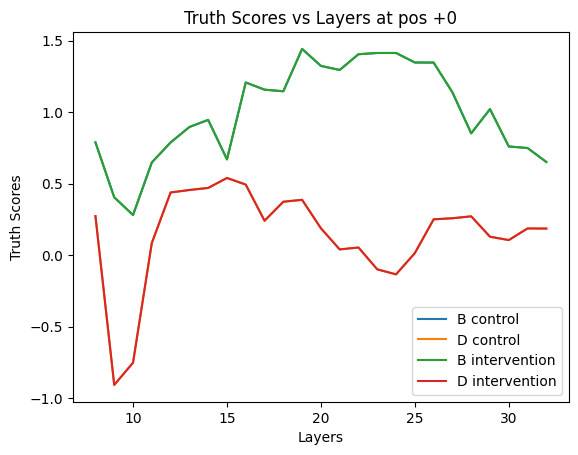

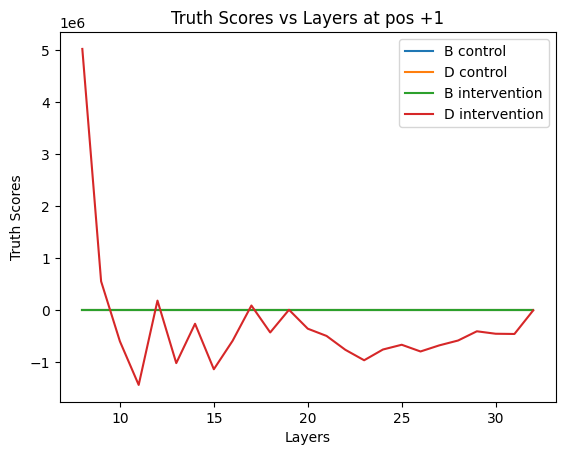

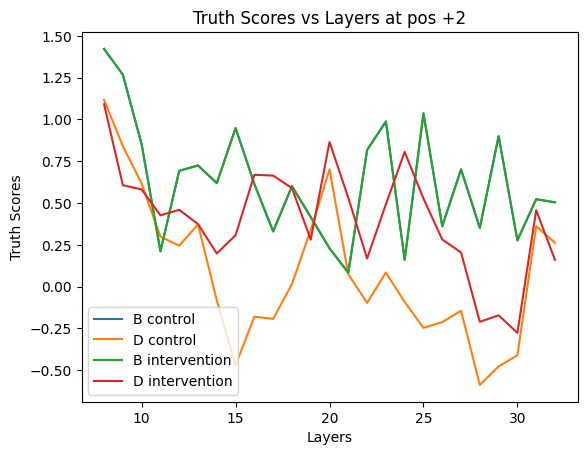

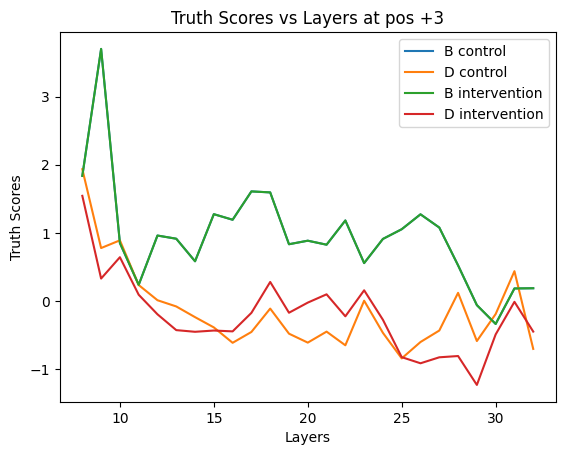

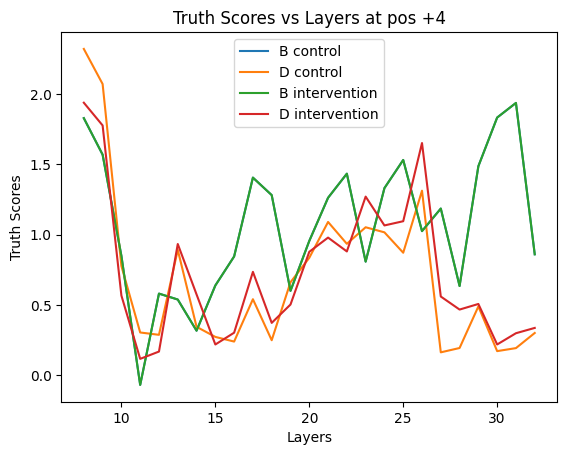

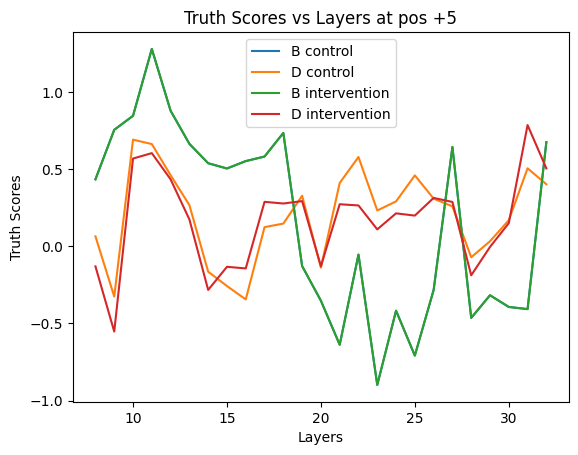

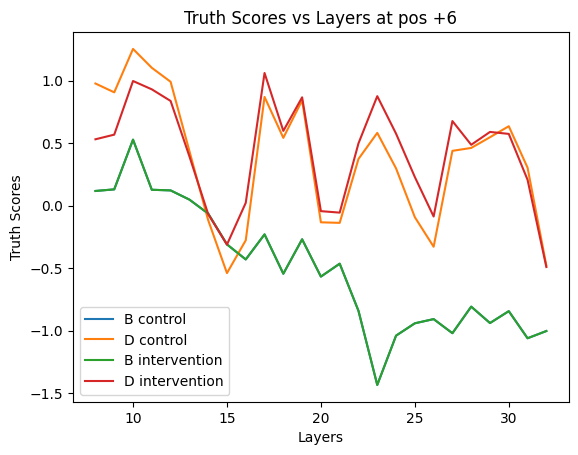

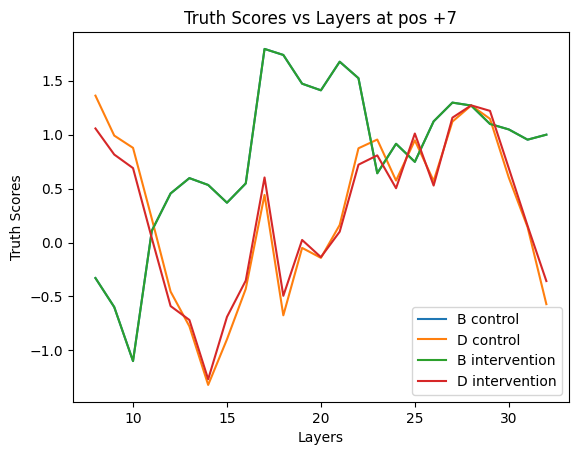

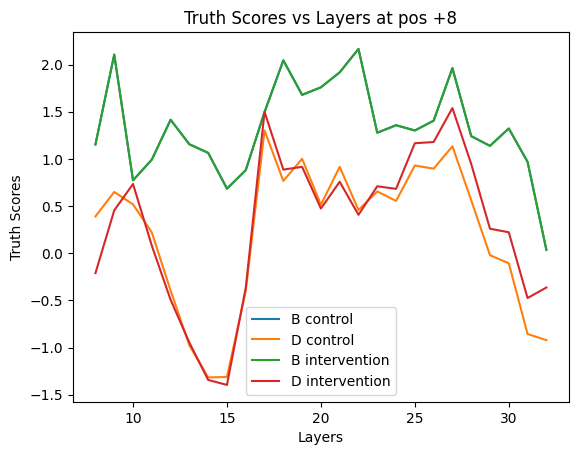

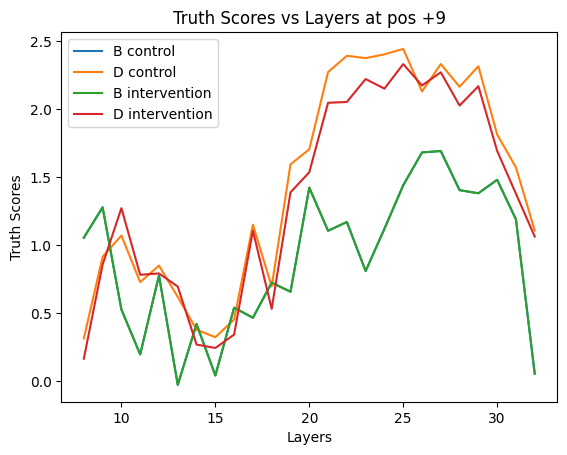

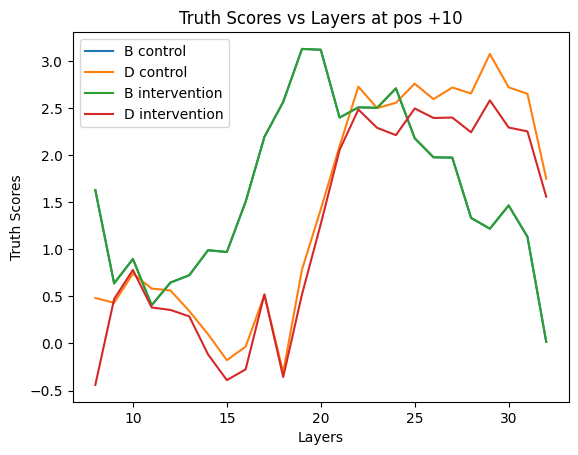

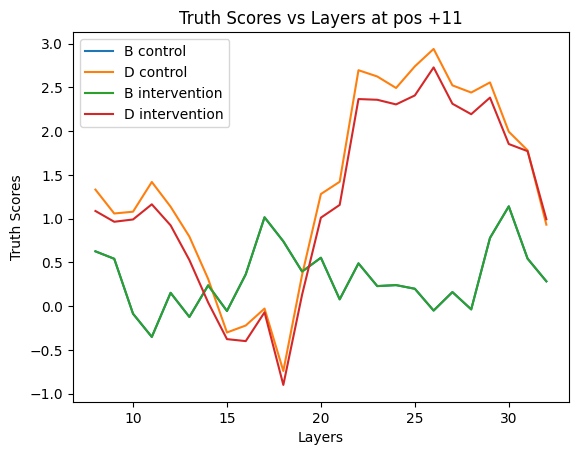

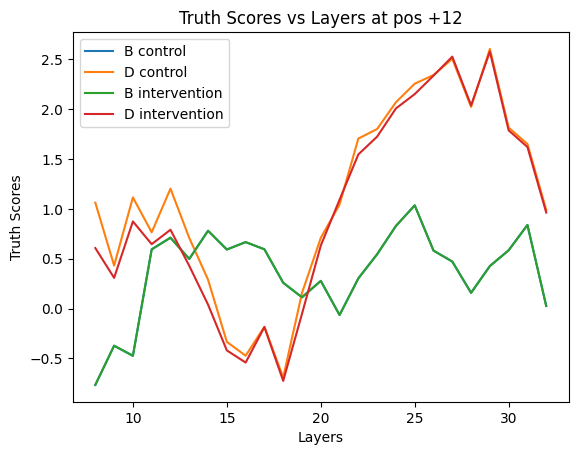

In [190]:
for pos_offset in range(0,13):

    ts_control_b = []
    ts_control_d = []

    ts_intervention_b = []
    ts_intervention_d = []

    for l in layers[8:]:
        ts_control = get_probe_truth_scores_for_options(
            h, probes[l], a_indices[0], b_indices[0], c_indices[0], d_indices[0], layer_idx=l, pos_offset=pos_offset
        )
        ts_control_b.append(ts_control[1])
        ts_control_d.append(ts_control[3])
        ts_intervention = get_probe_truth_scores_for_options(
            h_wrapped, probes[l], a_indices[0], b_indices[0], c_indices[0], d_indices[0], layer_idx=l, pos_offset=pos_offset
        )
        ts_intervention_b.append(ts_intervention[1])
        ts_intervention_d.append(ts_intervention[3])

    plt.plot(layers[8:], ts_control_b, label='B control')
    plt.plot(layers[8:], ts_control_d, label='D control')

    plt.plot(layers[8:], ts_intervention_b, label='B intervention')
    plt.plot(layers[8:], ts_intervention_d, label='D intervention')
    plt.xlabel('Layers')
    plt.ylabel('Truth Scores')
    plt.title(f'Truth Scores vs Layers at pos +{pos_offset}')
    plt.legend()
    plt.show()

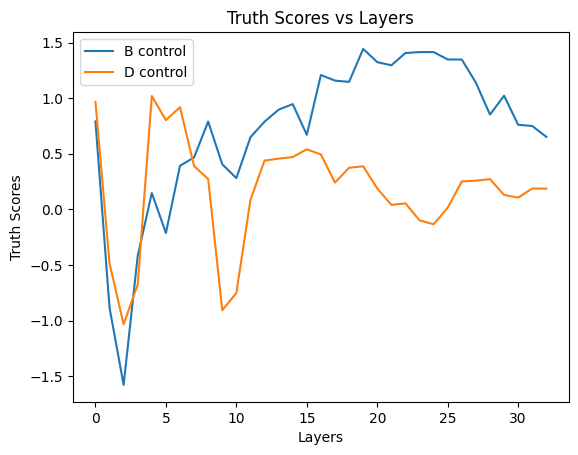

In [159]:
import matplotlib.pyplot as plt

plt.plot(layers, ts_control_b, label='B control')
plt.plot(layers, ts_control_d, label='D control')

# plt.plot(layers, ts_intervention_b, label='B intervention')
# plt.plot(layers, ts_intervention_d, label='D intervention')
plt.xlabel('Layers')
plt.ylabel('Truth Scores')
plt.title('Truth Scores vs Layers')
plt.legend()
plt.show()